In [13]:
# Ścieżka do pliku
# seq_file_name = '600_56n17_1mm_-161_09_29_59_808'
# seq_file_name = '600_41n20_1_2mm_-161_08_03_50_784'
# seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
seq_file_name='600_41n20_1_2mm_-161_08_05_51_044'

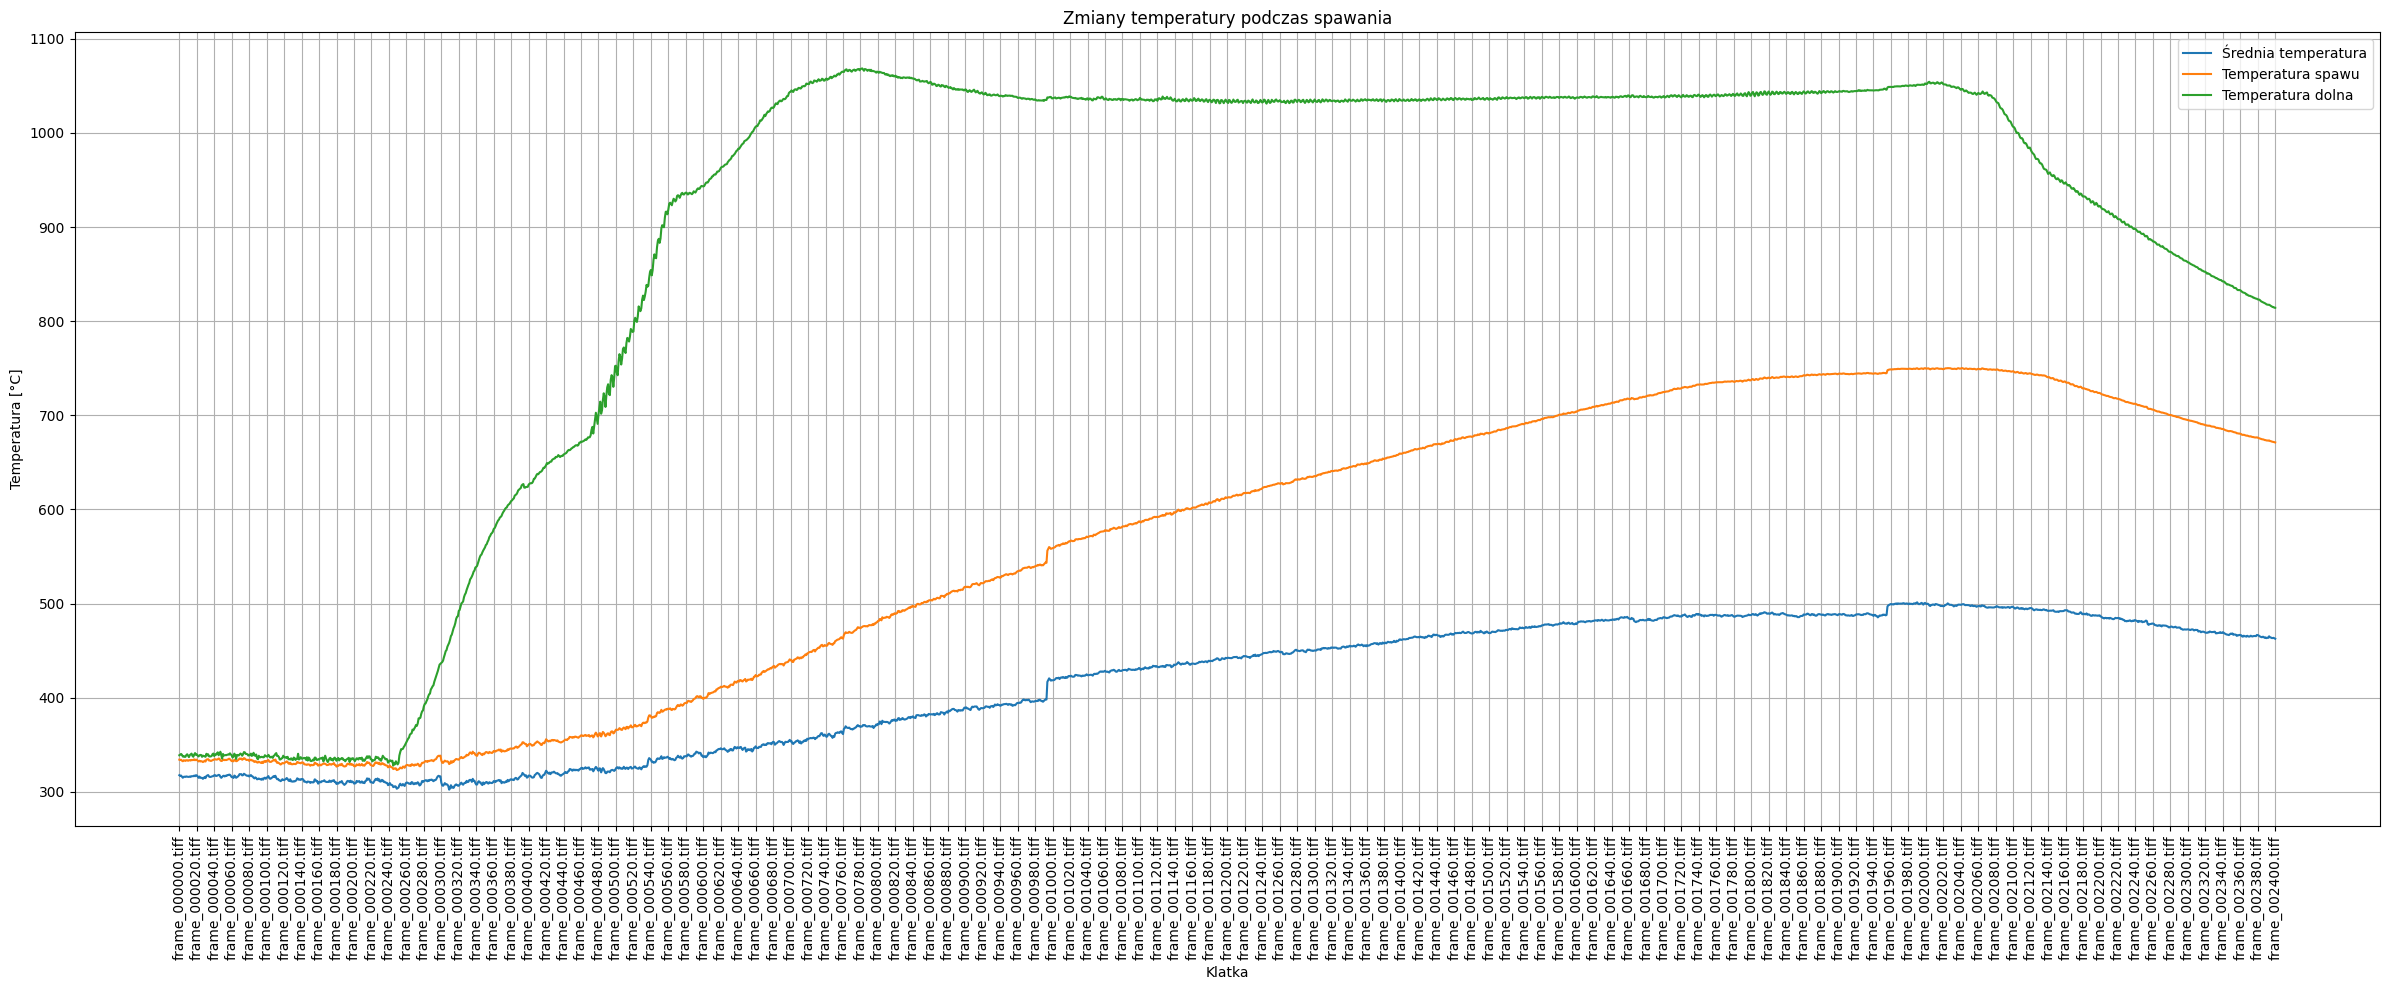

Wykryte anomalie:
                  Frame  MinTemp  MaxTemp    AvgTemp  WeldAvgTemp  \
994   frame_000994.tiff  -273.15  5964.85  416.82166    556.16705   
1956  frame_001956.tiff  -273.15  5964.85  496.90723    747.81670   

      WeldStdTemp  BottomAvgTemp  BottomHotPx  MiddleAvgTemp  FrameNumber  \
994     295.14572      1037.7614         3193       599.5819          994   
1956    181.97906      1048.2104         3197       774.8584         1956   

      TempDiff  
994   18.83042  
1956   8.93553  


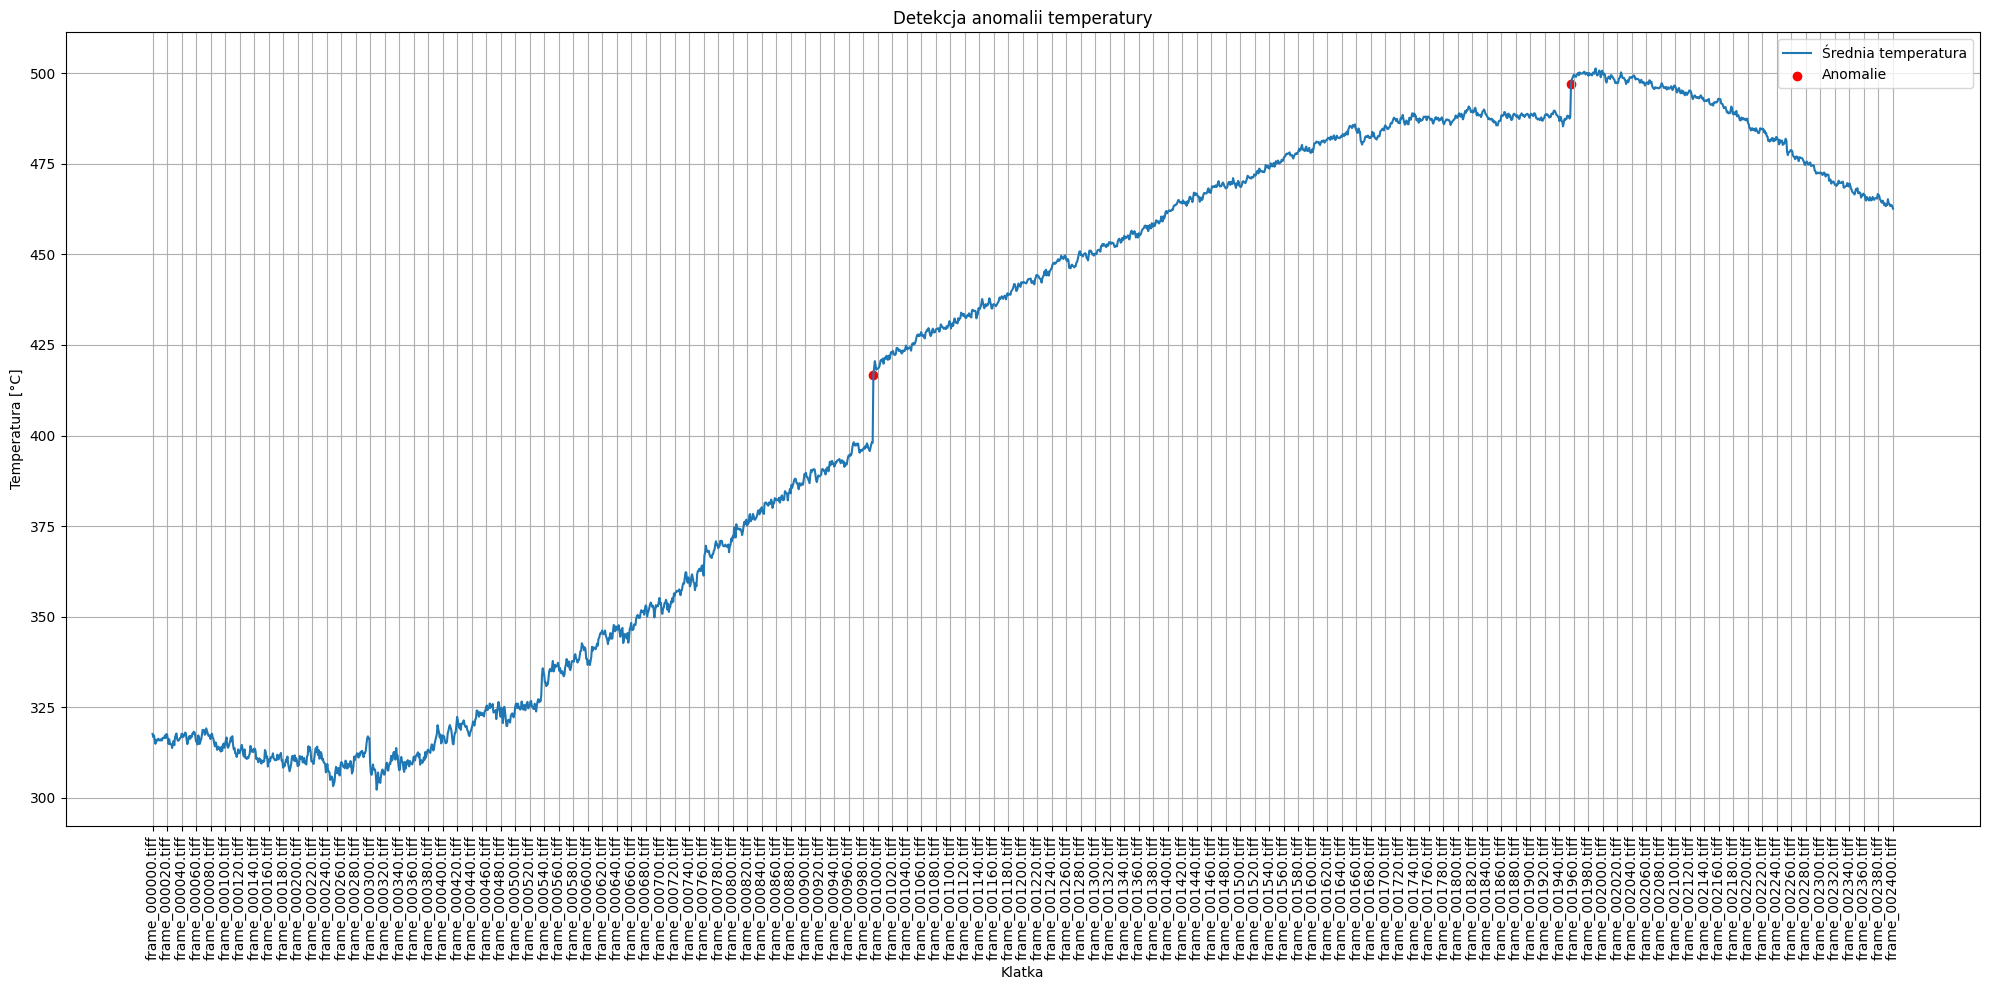

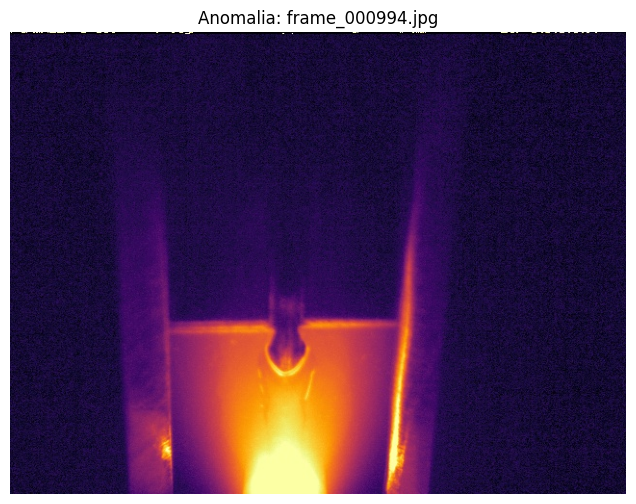

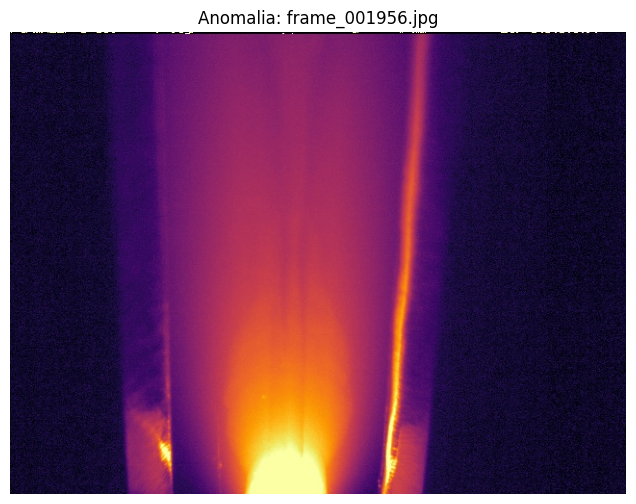

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


csv_path = f'../frames_output/{seq_file_name}/temperature_stats.csv'

# Wczytaj dane
df = pd.read_csv(csv_path)

df.head()

plt.figure(figsize=(24,10))
plt.plot(df['Frame'], df['AvgTemp'], label='Średnia temperatura')
plt.plot(df['Frame'], df['WeldAvgTemp'], label='Temperatura spawu')
plt.plot(df['Frame'], df['BottomAvgTemp'], label='Temperatura dolna')
step = 20
plt.xticks(ticks=range(0, len(df), step), labels=df['Frame'][::step], rotation=90)

plt.xticks(rotation=90)
plt.xlabel('Klatka')
plt.ylabel('Temperatura [°C]')
plt.title('Zmiany temperatury podczas spawania')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

df['FrameNumber'] = df['Frame'].apply(lambda x: int(x.split('_')[1].split('.')[0]))

# I teraz zamiast 'Frame' użyj 'FrameNumber' jako X
# plt.figure(figsize=(20,10))
# plt.plot(df['FrameNumber'], df['AvgTemp'], label='Średnia temperatura')

# Oblicz różnicę temperatury między kolejnymi klatkami
df['TempDiff'] = df['AvgTemp'].diff()

# Wykryj anomalie: różnica większa niż próg
threshold = 8  # możesz dostroić
anomalies = df[df['TempDiff'].abs() > threshold]

print("Wykryte anomalie:")
print(anomalies)

plt.figure(figsize=(20,10))
plt.plot(df['Frame'], df['AvgTemp'], label='Średnia temperatura')
plt.scatter(anomalies['Frame'], anomalies['AvgTemp'], color='red', label='Anomalie')

# Ustawienia osi X
step = 20
plt.xticks(ticks=range(0, len(df), step), labels=df['Frame'][::step], rotation=90)

plt.xticks(rotation=90)
plt.xlabel('Klatka')
plt.ylabel('Temperatura [°C]')
plt.title('Detekcja anomalii temperatury')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

from PIL import Image
import os

image_folder = f'../frames_output/{seq_file_name}/preview_fixed/'

for frame_name in anomalies['Frame']:
    # Zamień nazwę pliku .tiff na .jpg (jeśli masz JPG-i)
    frame_name_jpg = frame_name.replace('.tiff', '.jpg')
    
    # Pełna ścieżka do pliku
    image_path = os.path.join(image_folder, frame_name_jpg)
    
    # Sprawdź czy plik istnieje
    if os.path.exists(image_path):
        # Wczytaj obraz
        img = Image.open(image_path)
        
        # Wyświetl obraz
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.title(f'Anomalia: {frame_name_jpg}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Nie znaleziono pliku: {frame_name_jpg}")

In [22]:
import pandas as pd

# Ścieżka do pliku
# seq_file_name = '625_38n18_1_2mm_-161_07_41_19_806'
# seq_file_name = '600_41n20_1_2mm_-161_08_03_50_784'
# seq_file_name = '600_41n20_1_2mm_-161_08_04_23_216'

# csv_path = f'../frames_output/{seq_file_name}/temperature_stats.csv'

# Załaduj dane
df = pd.read_csv(f"../frames_output/{seq_file_name}/temperature_stats.csv")

# Policz zmiany pomiędzy klatkami
df['AvgTempDiff'] = df['AvgTemp'].diff()
df['WeldAvgTempDiff'] = df['WeldAvgTemp'].diff()
df['BottomHotPxDiff'] = df['BottomHotPx'].diff()


# --- Funkcja scoringu anomalii ---
def calculate_anomaly_score(row, thresholds):
    score = 0
    
    # Sprawdzanie poszczególnych warunków
    if abs(row['AvgTempDiff']) > thresholds['AvgTempDiff']:
        score += 1
    if abs(row['WeldAvgTempDiff']) > thresholds['WeldAvgTempDiff']:
        score += 1
    if abs(row['BottomHotPxDiff']) > thresholds['BottomHotPxDiff']:
        score += 1
    if row['WeldStdTemp'] > thresholds['WeldStdTemp']:
        score += 1
    if row['BottomAvgTemp'] < thresholds['BottomAvgTempLow']:
        score += 1
        
    return score

# --- Definicja progów ---
thresholds = {
    'AvgTempDiff': 10,          # skok średniej temperatury >10°C
    'WeldAvgTempDiff': 5,       # zmiana temperatury spoiny >8°C
    'BottomHotPxDiff': 10,       # zmiana liczby gorących pikseli >5
    'WeldStdTemp': 80,          # odchylenie temperatury spoiny >80°C
    'BottomAvgTempLow': 300     # średnia dolna temperatura <300°C (podejrzenie gaśnięcia łuku)
}

# --- Zastosowanie scoringu ---
df['AnomalyScore'] = df.apply(lambda row: calculate_anomaly_score(row, thresholds), axis=1)

# --- Oznacz anomalie ---
df['Anomaly'] = df['AnomalyScore'] >= 2  # uznajemy za anomalię jeśli score >= 2

# --- Wypisz anomalne klatki ---
anomalies = df[df['Anomaly']]

print(f"\n🔎 Wykryto {len(anomalies)} anomalnych klatek.")
print(anomalies[['Frame', 'AvgTemp', 'WeldAvgTemp', 'BottomAvgTemp', 'BottomHotPx', 'AnomalyScore']])

# --- (opcjonalnie) Zapisz anomalie do osobnego CSV ---
anomalies.to_csv(f"../frames_output/{seq_file_name}/anomalies_detected.csv", index=False)


🔎 Wykryto 141 anomalnych klatek.
                 Frame    AvgTemp  WeldAvgTemp  BottomAvgTemp  BottomHotPx  \
299  frame_000299.tiff  316.41425    338.40686      436.09412          786   
300  frame_000300.tiff  309.80066    333.35443      436.92743          798   
301  frame_000301.tiff  306.94827    330.90964      437.78833          822   
302  frame_000302.tiff  306.38266    330.74832      439.37668          840   
303  frame_000303.tiff  307.54706    331.96432      442.97864          860   
..                 ...        ...          ...            ...          ...   
551  frame_000551.tiff  336.21365    385.04645      887.75280         3150   
552  frame_000552.tiff  337.78120    387.07526      898.66540         3174   
553  frame_000553.tiff  334.87990    385.07095      901.97845         3187   
556  frame_000556.tiff  336.18920    387.12573      910.04720         3196   
994  frame_000994.tiff  416.82166    556.16705     1037.76140         3193   

     AnomalyScore  
299      

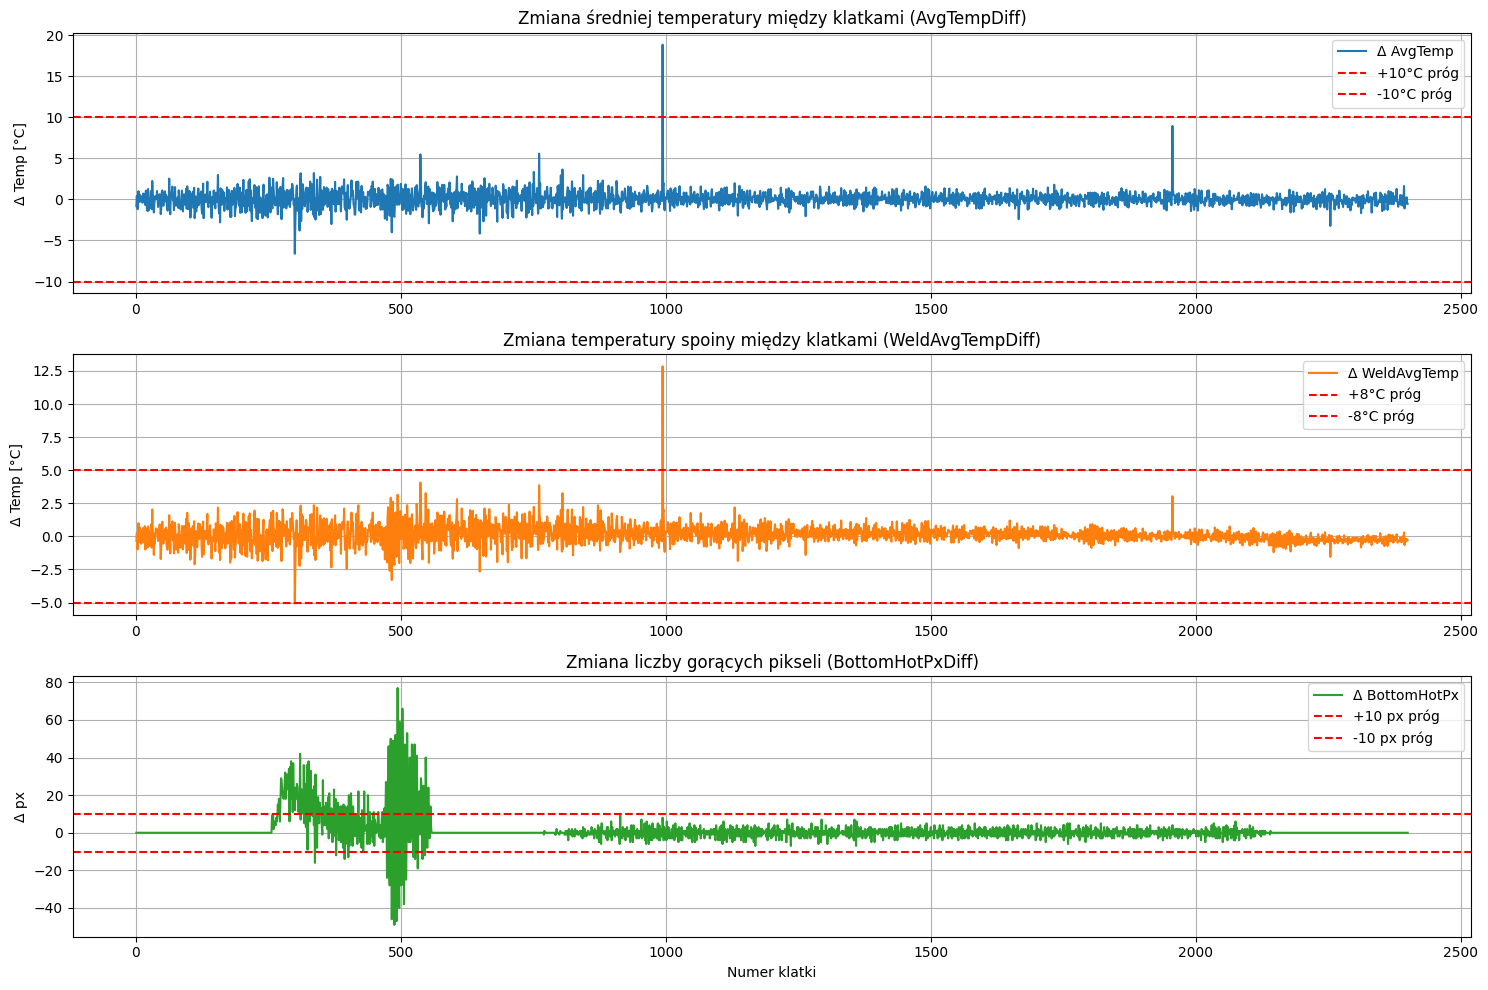

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Załaduj dane
df = pd.read_csv(f"../frames_output/{seq_file_name}/temperature_stats.csv")
df = df.reset_index()

# Oblicz różnice
df['AvgTempDiff'] = df['AvgTemp'].diff()
df['WeldAvgTempDiff'] = df['WeldAvgTemp'].diff()
df['BottomHotPxDiff'] = df['BottomHotPx'].diff()

# Wykres
plt.figure(figsize=(15, 10))

# 1. AvgTempDiff
plt.subplot(3, 1, 1)
plt.plot(df['index'], df['AvgTempDiff'], label='Δ AvgTemp', color='tab:blue')
plt.axhline(y=thresholds['AvgTempDiff'], color='red', linestyle='--', label='+10°C próg')
plt.axhline(y=-thresholds['AvgTempDiff'], color='red', linestyle='--', label='-10°C próg')
plt.title('Zmiana średniej temperatury między klatkami (AvgTempDiff)')
plt.ylabel('Δ Temp [°C]')
plt.legend()
plt.grid(True)

# 2. WeldAvgTempDiff
plt.subplot(3, 1, 2)
plt.plot(df['index'], df['WeldAvgTempDiff'], label='Δ WeldAvgTemp', color='tab:orange')
plt.axhline(y=thresholds['WeldAvgTempDiff'], color='red', linestyle='--', label='+8°C próg')
plt.axhline(y=-thresholds['WeldAvgTempDiff'], color='red', linestyle='--', label='-8°C próg')
plt.title('Zmiana temperatury spoiny między klatkami (WeldAvgTempDiff)')
plt.ylabel('Δ Temp [°C]')
plt.legend()
plt.grid(True)

# 3. BottomHotPxDiff
plt.subplot(3, 1, 3)
plt.plot(df['index'], df['BottomHotPxDiff'], label='Δ BottomHotPx', color='tab:green')
plt.axhline(y=thresholds['BottomHotPxDiff'], color='red', linestyle='--', label='+10 px próg')
plt.axhline(y=-thresholds['BottomHotPxDiff'], color='red', linestyle='--', label='-10 px próg')
plt.title('Zmiana liczby gorących pikseli (BottomHotPxDiff)')
plt.xlabel('Numer klatki')
plt.ylabel('Δ px')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# import cv2
# import matplotlib.pyplot as plt
# import pandas as pd
# import os

# # Załaduj dane z wykrytymi anomaliami
# anomalies = pd.read_csv("../frames_output/625_38n18_1_2mm_-161_07_41_19_806/anomalies_detected.csv")

# # Folder z zapisanymi obrazkami podglądów
# preview_fixed_dir = "../frames_output/625_38n18_1_2mm_-161_07_41_19_806/preview_fixed/"

# # Przygotuj wykres
# fig, axes = plt.subplots(nrows=len(anomalies), ncols=2, figsize=(10, len(anomalies) * 5))

# # Upewnij się, że są odpowiednie wymiary wykresu
# if len(anomalies) == 1:
#     axes = [axes]

# # Dla każdej wykrytej anomalii
# for i, row in anomalies.iterrows():
#     frame_name = row['Frame']
    
#     # Ścieżka do podglądu obrazu
#     image_path = os.path.join(preview_fixed_dir, frame_name.replace(".tiff", ".jpg"))
    
#     # Wczytaj obrazek
#     img = cv2.imread(image_path)
    
#     # Konwertuj obrazek do RGB, bo OpenCV ładuje w BGR
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     # Statystyki anomalii
#     stats = f"AvgTemp: {row['AvgTemp']:.2f}°C\n" \
#             f"WeldAvgTemp: {row['WeldAvgTemp']:.2f}°C\n" \
#             f"BottomAvgTemp: {row['BottomAvgTemp']:.2f}°C\n" \
#             f"BottomHotPx: {row['BottomHotPx']}\n" \
#             f"Anomaly Score: {row['AnomalyScore']}"
    
#     # Wyświetl obrazek i statystyki
#     axes[i][0].imshow(img_rgb)
#     axes[i][0].axis('off')
#     axes[i][0].set_title(f"Anomalna Klatka: {frame_name}")
    
#     axes[i][1].text(0.5, 0.5, stats, fontsize=12, ha='center', va='center')
#     axes[i][1].axis('off')

# # Dopasuj wykresy
# plt.tight_layout()
# plt.show()

In [1]:
# import cv2
# import matplotlib.pyplot as plt
# import pandas as pd
# import os

# # Załaduj dane z wykrytymi anomaliami
# anomalies = pd.read_csv("../frames_output/625_38n18_1_2mm_-161_07_41_19_806/anomalies_detected.csv")

# # Folder z zapisanymi obrazkami podglądów
# preview_fixed_dir = "../frames_output/625_38n18_1_2mm_-161_07_41_19_806/preview_fixed/"

# # Dla każdej wykrytej anomalii — osobny wykres (nie wielka siatka!)
# for i, row in anomalies.iterrows():
#     frame_name = row['Frame']
    
#     # Ścieżka do podglądu obrazu
#     image_path = os.path.join(preview_fixed_dir, frame_name.replace(".tiff", ".jpg"))
    
#     # Wczytaj obrazek
#     img = cv2.imread(image_path)
    
#     # Obsługa błędu gdy plik nie istnieje
#     if img is None:
#         print(f"❌ Nie znaleziono pliku: {image_path}")
#         continue
    
#     # Konwersja koloru + opcjonalne skalowanie
#     img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_rgb = cv2.resize(img_rgb, (640, 480))  # zmniejsz dla oszczędności
    
#     # Statystyki anomalii
#     stats = f"Średnia temperatura: {row['AvgTemp']:.2f}°C\n" \
#             f"TEMP (spoiny): {row['WeldAvgTemp']:.2f}°C\n" \
#             f"TEMP (dół): {row['BottomAvgTemp']:.2f}°C\n" \
#             f"HotPix w dole: {row['BottomHotPx']}\n" \
#             f"Anomaly Score: {row['AnomalyScore']:.4f}"
    
#     # Stwórz figurę
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
#     # Obraz
#     axes[0].imshow(img_rgb)
#     axes[0].axis('off')
#     axes[0].set_title(f"Klatka anomalii: {frame_name}")
    
#     # Statystyki
#     axes[1].text(0.5, 0.5, stats, fontsize=12, ha='center', va='center')
#     axes[1].axis('off')
    
#     plt.tight_layout()
#     plt.show()


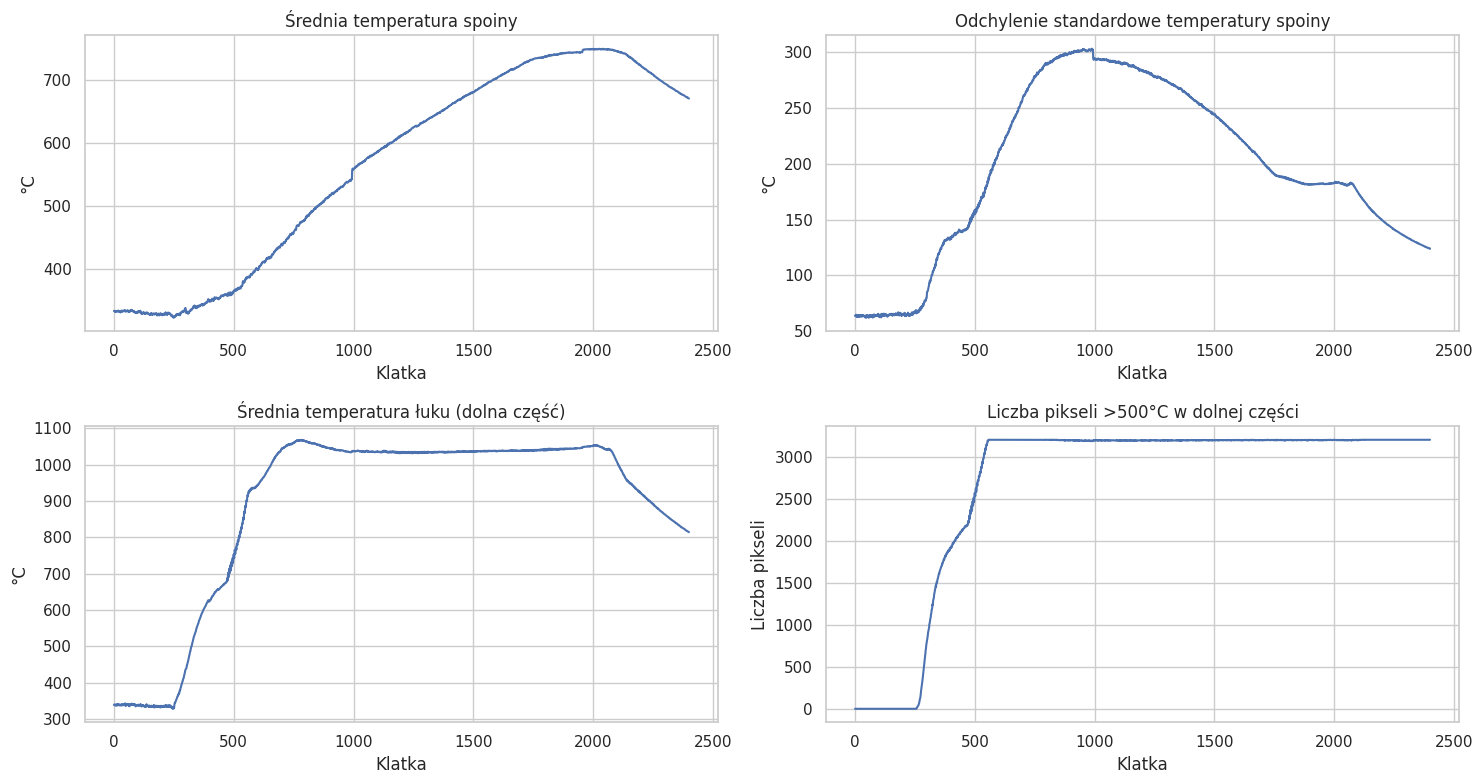

In [24]:
# # Konwersja kolumny Frame do sortowania
# df['FrameID'] = df['Frame'].str.extract(r'(\d+)').astype(int)
# df = df.sort_values(by='FrameID')

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Styl wykresów
# sns.set(style="whitegrid")
# plt.figure(figsize=(15, 8))

# # Wykres: Średnia temperatura spoiny
# plt.subplot(2, 2, 1)
# sns.lineplot(data=df, x='FrameID', y='WeldAvgTemp')
# plt.title("Średnia temperatura spoiny")
# plt.xlabel("Klatka")
# plt.ylabel("°C")

# # Wykres: Odchylenie standardowe (zmienność)
# plt.subplot(2, 2, 2)
# sns.lineplot(data=df, x='FrameID', y='WeldStdTemp')
# plt.title("Odchylenie standardowe temperatury spoiny")
# plt.xlabel("Klatka")
# plt.ylabel("°C")

# # Wykres: Temperatura łuku
# plt.subplot(2, 2, 3)
# sns.lineplot(data=df, x='FrameID', y='BottomAvgTemp')
# plt.title("Średnia temperatura łuku (dolna część)")
# plt.xlabel("Klatka")
# plt.ylabel("°C")

# # Wykres: Ilość gorących pikseli
# plt.subplot(2, 2, 4)
# sns.lineplot(data=df, x='FrameID', y='BottomHotPx')
# plt.title("Liczba pikseli >500°C w dolnej części")
# plt.xlabel("Klatka")
# plt.ylabel("Liczba pikseli")

# plt.tight_layout()
# plt.show()

PYTORCH SHIIIIT

Epoch 0, Loss: 0.0007
Epoch 10, Loss: 0.0033
Epoch 20, Loss: 0.0012
Epoch 30, Loss: 0.0007
Epoch 40, Loss: 0.0027
Epoch 50, Loss: 0.0022
Epoch 60, Loss: 0.0009
Epoch 70, Loss: 0.0031
Epoch 80, Loss: 0.0013
Epoch 90, Loss: 0.0018


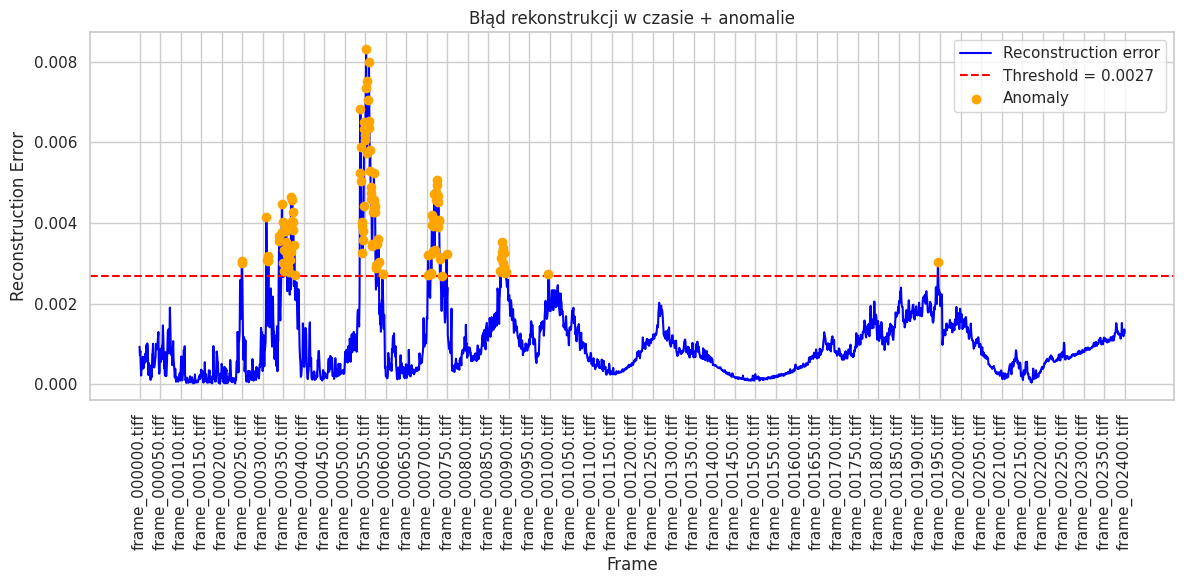

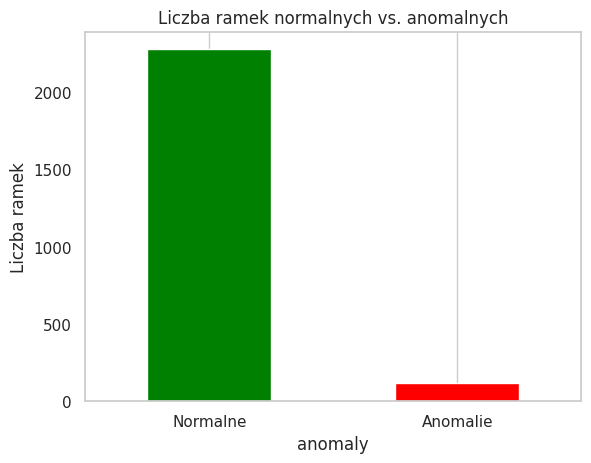

In [35]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Wczytaj dane
df = pd.read_csv(f"../frames_output/{seq_file_name}/temperature_stats.csv")

# Wybierz kolumny numeryczne (bez 'Frame' i Min/MaxTemp jeśli nie są istotne)
features = df[['AvgTemp', 'WeldAvgTemp', 'WeldStdTemp', 'BottomAvgTemp', 'MiddleAvgTemp']]

# Normalizacja (bardzo ważne dla autoenkodera)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Zamiana na tensory
X = torch.tensor(features_scaled, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4),
            nn.ReLU(),
            nn.Linear(4, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder(input_dim=X.shape[1])

import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    for batch in loader:
        x_batch = batch[0]
        output = model(x_batch)
        loss = criterion(output, x_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


# Przeanalizuj cały zbiór danych po treningu
with torch.no_grad():
    recon = model(X)
    errors = torch.mean((recon - X) ** 2, dim=1)  # MSE per sample

# Dodaj do DataFrame
df['reconstruction_error'] = errors.numpy()

# Przykład: oznacz anomalie gdy błąd > próg (np. 95 percentyl)
threshold = df['reconstruction_error'].quantile(0.95)
df['anomaly'] = df['reconstruction_error'] > threshold

df[['Frame', 'reconstruction_error', 'anomaly']]

df_anomalies = df[df['anomaly']]
df_anomalies

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Frame'], df['reconstruction_error'], label='Reconstruction error', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')

# Zaznaczenie anomalii
anomalies = df[df['anomaly']]
plt.scatter(anomalies['Frame'], anomalies['reconstruction_error'], color='orange', label='Anomaly', zorder=5)

plt.xlabel('Frame')
plt.ylabel('Reconstruction Error')
plt.title('Błąd rekonstrukcji w czasie + anomalie')
plt.xticks(rotation=45)

# Ustawienia osi X
step = 50
plt.xticks(ticks=range(0, len(df), step), labels=df['Frame'][::step], rotation=90)


plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


df['anomaly'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Liczba ramek normalnych vs. anomalnych')
plt.xticks(ticks=[0, 1], labels=['Normalne', 'Anomalie'], rotation=0)
plt.ylabel('Liczba ramek')
plt.grid(axis='y')
plt.show()

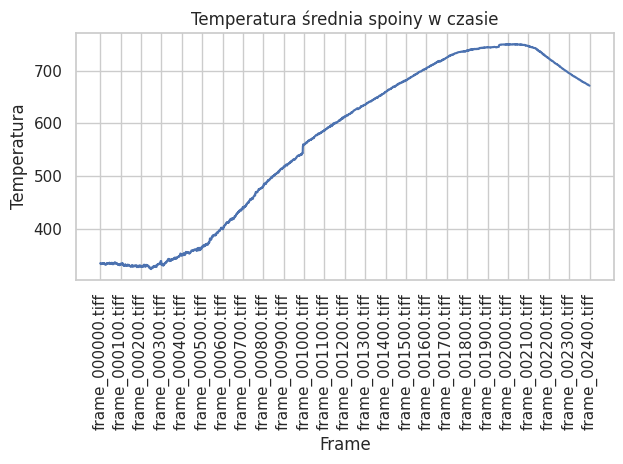

In [33]:
# plt.plot(df['Frame'], df['WeldAvgTemp'], label='WeldAvgTemp')
# plt.xticks(rotation=45)

# # Ustawienia osi X
# step = 100
# plt.xticks(ticks=range(0, len(df), step), labels=df['Frame'][::step], rotation=90)


# plt.title('Temperatura średnia spoiny w czasie')
# plt.ylabel('Temperatura')
# plt.xlabel('Frame')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

Epoch 1/50, Loss: 6.0219
Epoch 2/50, Loss: 0.4606
Epoch 3/50, Loss: 0.1927
Epoch 4/50, Loss: 0.1473
Epoch 5/50, Loss: 0.1267
Epoch 6/50, Loss: 0.1133
Epoch 7/50, Loss: 0.1024
Epoch 8/50, Loss: 0.0944
Epoch 9/50, Loss: 0.0859
Epoch 10/50, Loss: 0.0784
Epoch 11/50, Loss: 0.0730
Epoch 12/50, Loss: 0.0689
Epoch 13/50, Loss: 0.0648
Epoch 14/50, Loss: 0.0608
Epoch 15/50, Loss: 0.0583
Epoch 16/50, Loss: 0.0552
Epoch 17/50, Loss: 0.0531
Epoch 18/50, Loss: 0.0504
Epoch 19/50, Loss: 0.0483
Epoch 20/50, Loss: 0.0468
Epoch 21/50, Loss: 0.0448
Epoch 22/50, Loss: 0.0432
Epoch 23/50, Loss: 0.0411
Epoch 24/50, Loss: 0.0401
Epoch 25/50, Loss: 0.0386
Epoch 26/50, Loss: 0.0375
Epoch 27/50, Loss: 0.0362
Epoch 28/50, Loss: 0.0351
Epoch 29/50, Loss: 0.0342
Epoch 30/50, Loss: 0.0333
Epoch 31/50, Loss: 0.0321
Epoch 32/50, Loss: 0.0313
Epoch 33/50, Loss: 0.0304
Epoch 34/50, Loss: 0.0296
Epoch 35/50, Loss: 0.0288
Epoch 36/50, Loss: 0.0282
Epoch 37/50, Loss: 0.0273
Epoch 38/50, Loss: 0.0268
Epoch 39/50, Loss: 0.

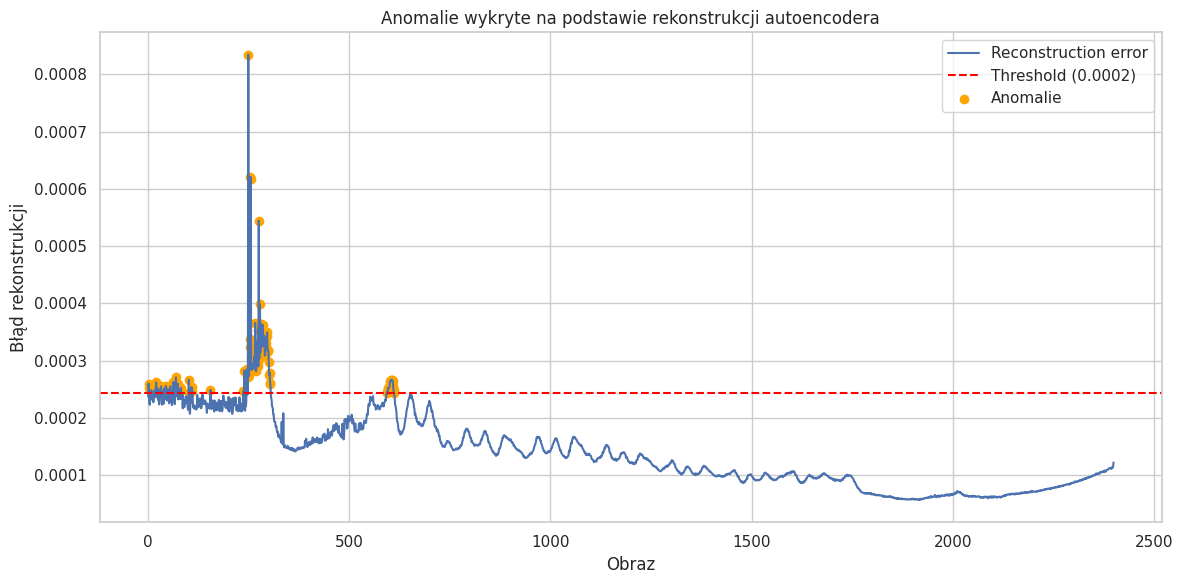

Obrazy potencjalnie anomalne:
frame_000001.jpg - error = 0.0003
frame_000002.jpg - error = 0.0003
frame_000008.jpg - error = 0.0002
frame_000015.jpg - error = 0.0002
frame_000017.jpg - error = 0.0002
frame_000019.jpg - error = 0.0003
frame_000020.jpg - error = 0.0003
frame_000021.jpg - error = 0.0002
frame_000023.jpg - error = 0.0003
frame_000026.jpg - error = 0.0002
frame_000029.jpg - error = 0.0002
frame_000031.jpg - error = 0.0003
frame_000032.jpg - error = 0.0003
frame_000033.jpg - error = 0.0002
frame_000037.jpg - error = 0.0002
frame_000039.jpg - error = 0.0002
frame_000040.jpg - error = 0.0003
frame_000044.jpg - error = 0.0003
frame_000045.jpg - error = 0.0003
frame_000050.jpg - error = 0.0003
frame_000053.jpg - error = 0.0002
frame_000055.jpg - error = 0.0003
frame_000056.jpg - error = 0.0002
frame_000062.jpg - error = 0.0002
frame_000063.jpg - error = 0.0003
frame_000064.jpg - error = 0.0002
frame_000067.jpg - error = 0.0003
frame_000069.jpg - error = 0.0003
frame_000070.jpg -

In [34]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# --- KONFIGURACJA ---
IMAGE_DIR = f'../frames_output/{seq_file_name}/preview_fixed'
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 16
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# --- PRZYGOTOWANIE DANYCH ---
transform = transforms.Compose([
    transforms.Grayscale(),  # konwersja do 1 kanału
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),  # skala 0–1
])

class ThermalDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        if self.transform:
            img = self.transform(img)
        return img, os.path.basename(self.files[idx])

dataset = ThermalDataset(IMAGE_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


# --- AUTOENCODER ---
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 8x8
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64
            nn.Sigmoid(),  # wyjście w zakresie 0–1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoencoder().to(DEVICE)


# --- TRENING ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    for batch, _ in dataloader:
        batch = batch.to(DEVICE)
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")


# --- DETEKCJA ANOMALII ---
model.eval()
reconstruction_errors = []
filenames = []

with torch.no_grad():
    for img, fname in DataLoader(dataset, batch_size=1, shuffle=False):
        img = img.to(DEVICE)
        recon = model(img)
        loss = criterion(recon, img)
        reconstruction_errors.append(loss.item())
        filenames.append(fname[0])

# --- WIZUALIZACJA ---
threshold = np.percentile(reconstruction_errors, 95)
is_anomaly = [e > threshold for e in reconstruction_errors]

plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction error')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')

anomalies = [i for i, a in enumerate(is_anomaly) if a]
plt.scatter(anomalies, [reconstruction_errors[i] for i in anomalies], color='orange', label='Anomalie')

plt.xlabel('Obraz')
plt.ylabel('Błąd rekonstrukcji')
plt.title('Anomalie wykryte na podstawie rekonstrukcji autoencodera')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PODGLĄD NAJWYŻSZYCH BŁĘDÓW ---
print("Obrazy potencjalnie anomalne:")
for i in anomalies:
    print(f"{filenames[i]} - error = {reconstruction_errors[i]:.4f}")

### RANDOM FOREST

In [41]:
import pandas as pd

# Wczytaj dane
df_all = pd.read_csv(f"../frames_output/{seq_file_name}/temperature_stats.csv")
df_anomalies = pd.read_csv(f"../frames_output/{seq_file_name}/anomalies_detected.csv")

# Zachowaj tylko kolumny z oznaczeniem anomalii
df_anomalies_labels = df_anomalies[["Frame", "Anomaly"]]

# Połącz dane
df_merged = df_all.merge(df_anomalies_labels, on="Frame", how="left")

# Uzupełnij brakujące etykiety jako False (czyli brak anomalii)
df_merged["Anomaly"] = df_merged["Anomaly"].fillna(False)

# Możesz wybrać takie cechy np.:
features = [
    "AvgTemp", "WeldAvgTemp", "WeldStdTemp",
    "BottomAvgTemp", "BottomHotPx", "MiddleAvgTemp"
]

X = df_merged[features]
y = df_merged["Anomaly"].astype(int)  # 0 = brak anomalii, 1 = anomalia


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Ewaluacja
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



/tmp/ipykernel_113379/3034995166.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged["Anomaly"] = df_merged["Anomaly"].fillna(False)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       454
           1       0.60      0.78      0.68        27

    accuracy                           0.96       481
   macro avg       0.79      0.87      0.83       481
weighted avg       0.96      0.96      0.96       481



In [ ]:
# import torch.nn.functional as F
# import numpy as np
# import matplotlib.pyplot as plt

# # Lista szczegółów
# detailed_anomalies = []

# model.eval()
# with torch.no_grad():
#     for i, (img, fname) in enumerate(DataLoader(dataset, batch_size=1, shuffle=False)):
#         img = img.to(DEVICE)
#         recon = model(img)
#         mse_map = F.mse_loss(recon, img, reduction='none').squeeze().cpu().numpy()
#         total_error = mse_map.mean()

#         if total_error > threshold:
#             # Klasyfikacja typu anomalii (proste heurystyki)
#             max_region_error = mse_map[24:40, 24:40].mean()  # centralna część
#             outside_error = (mse_map.sum() - max_region_error * 16 * 16) / (64*64 - 256)

#             if max_region_error < 0.001:  # środek ciemny = brak łuku
#                 anomaly_type = "Brak łuku"
#             elif max_region_error < outside_error * 1.2:  # środek nie jest gorętszy niż reszta
#                 anomaly_type = "Łuk przesunięty"
#             else:
#                 anomaly_type = "Inna anomalia (np. artefakt/kształt)"

#             detailed_anomalies.append({
#                 "filename": fname[0],
#                 "error": total_error,
#                 "type": anomaly_type,
#                 "mse_map": mse_map,
#                 "image": img.squeeze().cpu().numpy(),
#                 "reconstruction": recon.squeeze().cpu().numpy(),
#             })

In [ ]:
# for item in detailed_anomalies[:5]:  # pokaż pierwsze 5
#     fig, axs = plt.subplots(1, 3, figsize=(12, 4))
#     axs[0].imshow(item['image'], cmap='gray')
#     axs[0].set_title('Oryginalny obraz')
#     axs[1].imshow(item['reconstruction'], cmap='gray')
#     axs[1].set_title('Rekonstrukcja')
#     axs[2].imshow(item['mse_map'], cmap='hot')
#     axs[2].set_title(f'Mapa błędu\n({item["type"]})')
#     plt.suptitle(f"{item['filename']} - {item['type']} - Error={item['error']:.4f}")
#     plt.tight_layout()
#     plt.show()

In [ ]:
# from collections import Counter
# counts = Counter(item['type'] for item in detailed_anomalies)

# plt.bar(counts.keys(), counts.values(), color='orange')
# plt.title("Rozkład typów anomalii")
# plt.ylabel("Liczba przypadków")
# plt.xticks(rotation=15)
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# import os
# import glob
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader

# # --- KONFIGURACJA ---
# IMAGE_DIR = f'frames_output/{seq_file_name}/preview_fixed'
# ROI = (295, 410, 345, 480)  # lewy, górny, prawy, dolny
# IMAGE_SIZE = (64, 64)  # zmniejszamy region
# BATCH_SIZE = 16
# EPOCHS = 50
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# # --- PRZYGOTOWANIE DANYCH ---
# transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize(IMAGE_SIZE),
#     transforms.ToTensor(),
# ])

# class ArcRegionDataset(Dataset):
#     def __init__(self, image_dir, transform=None):
#         self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
#         self.transform = transform

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         img = Image.open(self.files[idx]).convert("L")
#         img = img.crop(ROI)
#         if self.transform:
#             img = self.transform(img)
#         return img, os.path.basename(self.files[idx])

# dataset = ArcRegionDataset(IMAGE_DIR, transform=transform)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


# # --- AUTOENCODER ---
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 8, 3, stride=2, padding=1),  # 16x16
#             nn.ReLU(),
#             nn.Conv2d(8, 16, 3, stride=2, padding=1),  # 8x8
#             nn.ReLU(),
#             nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 4x4
#             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # 8x8
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),  # 16x16
#             nn.ReLU(),
#             nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),  # 32x32
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.decoder(self.encoder(x))

# model = ConvAutoencoder().to(DEVICE)


# # --- TRENING ---
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(EPOCHS):
#     model.train()
#     epoch_loss = 0.0
#     for batch, _ in dataloader:
#         batch = batch.to(DEVICE)
#         output = model(batch)
#         loss = criterion(output, batch)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")


# # --- DETEKCJA ANOMALII ---
# model.eval()
# reconstruction_errors = []
# filenames = []

# with torch.no_grad():
#     for img, fname in DataLoader(dataset, batch_size=1, shuffle=False):
#         img = img.to(DEVICE)
#         recon = model(img)
#         loss = criterion(recon, img)
#         reconstruction_errors.append(loss.item())
#         filenames.append(fname[0])

# # --- ANALIZA ---
# threshold = np.percentile(reconstruction_errors, 95)
# is_anomaly = [e > threshold for e in reconstruction_errors]

# plt.figure(figsize=(12, 6))
# plt.plot(reconstruction_errors, label='Reconstruction error')
# plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')

# anomalies = [i for i, a in enumerate(is_anomaly) if a]
# plt.scatter(anomalies, [reconstruction_errors[i] for i in anomalies], color='orange', label='Anomalie')

# plt.xlabel('Obraz')
# plt.ylabel('Błąd rekonstrukcji')
# plt.title('Anomalie w obszarze łuku')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print("Wykryte anomalie:")
# for i in anomalies:
#     print(f"{filenames[i]} — error = {reconstruction_errors[i]:.4f}")

In [ ]:
# import os
# import glob
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader

# # --- KONFIGURACJA ---
# IMAGE_DIR = f'frames_output/{seq_file_name}/preview_fixed'
# # IMAGE_DIR = f'frames_output/{seq_file_name}/no_ignition'
# IMAGE_SIZE = (64, 64)
# BATCH_SIZE = 16
# EPOCHS = 50
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# # --- TRANSFORMACJE ---
# transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize(IMAGE_SIZE),
#     transforms.ToTensor(),
# ])

# # --- DANE Z 2 ROIs ---
# class ThermalDatasetMultiROI(Dataset):
#     def __init__(self, image_dir, transform=None):
#         self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
#         self.transform = transform
#         self.roi_arc = (295, 410, 345, 480)   # ROI łuku
#         self.roi_weld = (270, 250, 370, 400)  # ROI spoiny

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         img = Image.open(self.files[idx])
#         arc_crop = img.crop(self.roi_arc)
#         weld_crop = img.crop(self.roi_weld)
#         if self.transform:
#             arc_crop = self.transform(arc_crop)
#             weld_crop = self.transform(weld_crop)
#         return arc_crop, weld_crop, os.path.basename(self.files[idx])

# # --- AUTOENCODER ---
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.decoder(self.encoder(x))

# # --- PRZYGOTOWANIE ---
# dataset = ThermalDatasetMultiROI(IMAGE_DIR, transform=transform)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# model_arc = ConvAutoencoder().to(DEVICE)
# model_weld = ConvAutoencoder().to(DEVICE)
# optimizer_arc = optim.Adam(model_arc.parameters(), lr=0.001)
# optimizer_weld = optim.Adam(model_weld.parameters(), lr=0.001)
# criterion = nn.MSELoss()

# # --- TRENING ---
# for epoch in range(EPOCHS):
#     model_arc.train()
#     model_weld.train()
#     loss_arc_sum, loss_weld_sum = 0.0, 0.0

#     for arc, weld, _ in dataloader:
#         arc = arc.to(DEVICE)
#         weld = weld.to(DEVICE)

#         out_arc = model_arc(arc)
#         loss_arc = criterion(out_arc, arc)
#         optimizer_arc.zero_grad()
#         loss_arc.backward()
#         optimizer_arc.step()
#         loss_arc_sum += loss_arc.item()

#         out_weld = model_weld(weld)
#         loss_weld = criterion(out_weld, weld)
#         optimizer_weld.zero_grad()
#         loss_weld.backward()
#         optimizer_weld.step()
#         loss_weld_sum += loss_weld.item()

#     print(f"Epoch {epoch+1}/{EPOCHS} | Arc Loss: {loss_arc_sum:.4f} | Weld Loss: {loss_weld_sum:.4f}")

# # --- DETEKCJA ANOMALII ---
# model_arc.eval()
# model_weld.eval()
# errors_arc = []
# errors_weld = []
# filenames = []

# with torch.no_grad():
#     for arc, weld, fname in DataLoader(dataset, batch_size=1, shuffle=False):
#         arc = arc.to(DEVICE)
#         weld = weld.to(DEVICE)

#         recon_arc = model_arc(arc)
#         recon_weld = model_weld(weld)

#         err_arc = criterion(recon_arc, arc).item()
#         err_weld = criterion(recon_weld, weld).item()

#         errors_arc.append(err_arc)
#         errors_weld.append(err_weld)
#         filenames.append(fname[0])

# # --- ANALIZA ---
# thresh_arc = np.percentile(errors_arc, 95)
# thresh_weld = np.percentile(errors_weld, 95)
# anomalies_arc = [i for i, e in enumerate(errors_arc) if e > thresh_arc]
# anomalies_weld = [i for i, e in enumerate(errors_weld) if e > thresh_weld]

# # --- WIZUALIZACJA ---
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(errors_arc, label='Arc Error')
# plt.axhline(y=thresh_arc, color='red', linestyle='--', label='Threshold')
# plt.scatter(anomalies_arc, [errors_arc[i] for i in anomalies_arc], color='orange', label='Anomalies')
# plt.title('Anomalie łuku')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(errors_weld, label='Weld Error')
# plt.axhline(y=thresh_weld, color='red', linestyle='--', label='Threshold')
# plt.scatter(anomalies_weld, [errors_weld[i] for i in anomalies_weld], color='orange', label='Anomalies')
# plt.title('Anomalie spoiny')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # --- WYDRUK ---
# print("Anomalie łuku:")
# for i in anomalies_arc:
#     print(f"{filenames[i]} - error = {errors_arc[i]:.4f}")

# print("\nAnomalie spoiny:")
# for i in anomalies_weld:
#     print(f"{filenames[i]} - error = {errors_weld[i]:.4f}")




In [ ]:
# plt.subplot(1,2,1)
# plt.imshow(original_image.squeeze().cpu(), cmap='gray')
# plt.title("Oryginał")
# plt.subplot(1,2,2)
# plt.imshow(reconstructed_image.squeeze().cpu(), cmap='gray')
# plt.title("Rekonstrukcja")
# plt.show()

In [ ]:
# torch.save(model_arc.state_dict(), "autoencoder_arc_reference.pth")
# torch.save(model_weld.state_dict(), "autoencoder_weld_reference.pth")

In [ ]:
# model_arc = ConvAutoencoder().to(DEVICE)
# model_weld = ConvAutoencoder().to(DEVICE)

# model_arc.load_state_dict(torch.load("autoencoder_arc_reference.pth"))
# model_weld.load_state_dict(torch.load("autoencoder_weld_reference.pth"))

# model_arc.eval()
# model_weld.eval()

INTERFACE LOADER

In [ ]:
# import os
# import glob
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# import torch.nn as nn
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader

# # --- ŚCIEŻKI ---
# NEW_IMAGE_DIR = f'frames_output/{seq_file_name}/preview_fixed'  # zmień na swój katalog
# MODEL_ARC_PATH = 'autoencoder_arc_reference.pth'
# MODEL_WELD_PATH = 'autoencoder_weld_reference.pth'
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# IMAGE_SIZE = (64, 64)

# # --- TRANSFORMACJE ---
# transform = transforms.Compose([
#     transforms.Grayscale(),
#     transforms.Resize(IMAGE_SIZE),
#     transforms.ToTensor(),
# ])

# # --- STRUKTURA MODELU ---
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.decoder(self.encoder(x))

# # --- ŁADOWANIE MODELÓW ---
# model_arc = ConvAutoencoder().to(DEVICE)
# model_arc.load_state_dict(torch.load(MODEL_ARC_PATH))
# model_arc.eval()

# model_weld = ConvAutoencoder().to(DEVICE)
# model_weld.load_state_dict(torch.load(MODEL_WELD_PATH))
# model_weld.eval()

# # --- DATASET Z ROIs ---
# class ThermalDatasetMultiROI(Dataset):
#     def __init__(self, image_dir, transform=None):
#         self.files = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
#         self.transform = transform
#         self.roi_arc = (295, 410, 345, 480)
#         self.roi_weld = (270, 250, 370, 400)

#     def __len__(self):
#         return len(self.files)

#     def __getitem__(self, idx):
#         img = Image.open(self.files[idx])
#         arc_crop = img.crop(self.roi_arc)
#         weld_crop = img.crop(self.roi_weld)
#         if self.transform:
#             arc_crop = self.transform(arc_crop)
#             weld_crop = self.transform(weld_crop)
#         return arc_crop, weld_crop, os.path.basename(self.files[idx])

# # --- DANE I PRZETWARZANIE ---
# dataset = ThermalDatasetMultiROI(NEW_IMAGE_DIR, transform=transform)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
# criterion = nn.MSELoss()

# errors_arc, errors_weld, filenames = [], [], []

# with torch.no_grad():
#     for arc, weld, fname in dataloader:
#         arc = arc.to(DEVICE)
#         weld = weld.to(DEVICE)

#         recon_arc = model_arc(arc)
#         recon_weld = model_weld(weld)

#         err_arc = criterion(recon_arc, arc).item()
#         err_weld = criterion(recon_weld, weld).item()

#         errors_arc.append(err_arc)
#         errors_weld.append(err_weld)
#         filenames.append(fname[0])

# # --- PROGI I WYKRYWANIE ---
# threshold_arc = np.percentile(errors_arc, 95)
# threshold_weld = np.percentile(errors_weld, 95)

# anomalies_arc = [i for i, e in enumerate(errors_arc) if e > threshold_arc]
# anomalies_weld = [i for i, e in enumerate(errors_weld) if e > threshold_weld]

# # --- WIZUALIZACJA ---
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(errors_arc, label="Arc Error")
# plt.axhline(threshold_arc, color='r', linestyle='--', label='Threshold')
# plt.scatter(anomalies_arc, [errors_arc[i] for i in anomalies_arc], color='orange', label='Anomalies')
# plt.title("Anomalie łuku")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(errors_weld, label="Weld Error")
# plt.axhline(threshold_weld, color='r', linestyle='--', label='Threshold')
# plt.scatter(anomalies_weld, [errors_weld[i] for i in anomalies_weld], color='orange', label='Anomalies')
# plt.title("Anomalie spoiny")
# plt.legend()

# plt.tight_layout()
# plt.show()

# # --- WYDRUK ---
# print("\n[ANOMALIE ŁUKU]")
# for i in anomalies_arc:
#     print(f"{filenames[i]} - error = {errors_arc[i]:.4f}")

# print("\n[ANOMALIE SPOINY]")
# for i in anomalies_weld:
#     print(f"{filenames[i]} - error = {errors_weld[i]:.4f}")